In [1]:
# load model

import cobra

# model originally from:
# Caspeta L, Shoaie S, Agren R, et al (2012) Genome-scale metabolic reconstructions of Pichia stipitis and Pichia pastoris and in silico evaluation of their potentials. BMC Syst Biol 6:24. doi: 10.1186/1752-0509-6-24.

# model with heterologous protein production was used as starting point for our simulation:
# Irani ZA, Kerkhoven EJ, Shojaosadati SA, Nielsen J (2016) Genome-scale metabolic model of Pichia pastoris with native and humanized glycosylation of recombinant proteins. Biotechnol Bioeng 113:961–969. doi: 10.1002/bit.25863.

# it is common for these models to give some warnings when uploaded for the first time, so in order to avoid them, it is just required to rewrite the model as follows

#pheast = cobra.io.read_sbml_model("./data/iLC915.xml")
#cobra.io.write_sbml_model(pheast,"./data/iLC915_rewritten.xml")

pheast = cobra.io.read_sbml_model("./data/iLC915_rewritten.xml")

In [2]:
cobra.io.write_sbml_model(pheast, "./data/test")

In [3]:
# first remove the heterologous protein production reactions from the paper

pheast.remove_reactions([pheast.reactions.r1337,
                        pheast.reactions.r1338,
                        pheast.reactions.r1100,
                        pheast.reactions.r1101,
                        pheast.reactions.r1102,
                        pheast.reactions.r1103,
                        pheast.reactions.EX_m1365])

pheast.remove_metabolites([pheast.metabolites.m1360,
                          pheast.metabolites.m1361,
                          pheast.metabolites.m1362,
                          pheast.metabolites.m1363,
                          pheast.metabolites.m1364,
                          pheast.metabolites.m1365])

/home/schmackeroodle/.local/lib/python3.9/site-packages/cobra/core/group.py:107: UserWarning: need to pass in a list
  warn("need to pass in a list")


In [4]:
# run the model/optimizes for cell growth

pheast.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
m1293,EX_m1293,1,0,0.00%
m1298,EX_m1298,0.7968,0,0.00%
m1300,EX_m1300,0.4628,0,0.00%
m1301,EX_m1301,0.03308,0,0.00%
m1304,EX_m1304,0.00246,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
m1287,EX_m1287,-0.0803,0,0.00%
m1291,EX_m1291,-1.597,0,0.00%
m1349,EX_m1349,-3.432,0,0.00%


In [5]:
# find glucose reactions (it can be seen that it is the carbon source being taken up at 1 mmol gDW^-1 h^-1)

pheast.metabolites.m1293.reactions

frozenset({<Reaction EX_m1293 at 0x7fefdaac14f0>,
           <Reaction r1145 at 0x7fef999d6ee0>})

In [6]:
# exchange reaction in general

pheast.reactions.EX_m1293


Reaction identifier,EX_m1293
Name,EX_m1293
Memory address,0x07fefdaac14f0
Stoichiometry,m1293 <=> alpha-D-Glucose_C6H12O6 <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [7]:
# this reaction seems to be the uptake from medium (it is defined in this model as boundary metabolites -> extracellular --> cytosolic
# and we have to define the medium boudary at reaction from boundary to extracellular)

pheast.reactions.r1145


Reaction identifier,r1145
Name,Uptake of alpha-D-Glucose
Memory address,0x07fef999d6ee0
Stoichiometry,m1293 --> m2 alpha-D-Glucose_C6H12O6 --> alpha-D-Glucose_C6H12O6
GPR,
Lower bound,0.0
Upper bound,1.0


In [8]:
# look for methanol

pheast.reactions.query("methanol", "name")

[<Reaction r1158 at 0x7fef99967a60>]

In [9]:
# this is methanol uptake

pheast.reactions.r1158

Reaction identifier,r1158
Name,uptake of methanol
Memory address,0x07fef99967a60
Stoichiometry,m1297 --> m1219 Methanol_CH4O --> Methanol_CH4O
GPR,
Lower bound,0.0
Upper bound,0.0


In [10]:
pheast.reactions.r1145.bounds = 0, 0  # no glucose 
pheast.reactions.r1158.bounds = 0, 1  # methanol at 1 mmol gDW^-1 h^-1

In [11]:
# it grows on methanol
pheast.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
m1297,EX_m1297,1,0,0.00%
m1298,EX_m1298,1.258,0,0.00%
m1300,EX_m1300,0.06602,0,0.00%
m1301,EX_m1301,0.004719,0,0.00%
m1304,EX_m1304,0.0003508,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
m1287,EX_m1287,-0.01145,0,0.00%
m1291,EX_m1291,-0.372,0,0.00%
m1349,EX_m1349,-1.643,0,0.00%


In [12]:
# no methane yet

pheast.metabolites.query("methane", "name")

[]

In [13]:
# we add methane

b_methane = cobra.Metabolite(
    'b_methane',
    formula='CH4',
    name='boundary_methane',
    compartment='C_b')
e_methane = cobra.Metabolite(
    'e_methane',
    formula='CH4',
    name='extracellular_methane',
    compartment='C_e')

pheast.add_metabolites([b_methane,e_methane])

In [14]:
# make reactions

EX_methane = cobra.Reaction(
            'EX_methane',
            name = 'Exchange Reaction Methane',
            lower_bound = -1000,
            upper_bound = 1000,
        )

uptake_methane = cobra.Reaction(
            'uptake_methane',
            name = 'Methane Uptake from Environent',
            lower_bound = 0,
            upper_bound = 1.0 # for now we allow a max uptake of methane of 1 mmol gDW^-1 h^-1
        )

methane_oxidation = cobra.Reaction(
            'methane_oxidation',
            name = 'methane oxidation',
            lower_bound = 0.0,
            upper_bound = 1000.0
    )

# add involved metabolites and stoichiometry

EX_methane.add_metabolites(
    {
        pheast.metabolites.b_methane: -1.0,
    }
)

uptake_methane.add_metabolites(
    {
        pheast.metabolites.b_methane: -1.0,
        pheast.metabolites.e_methane: 1.0
    }
)

# pMMO reaction without redox coenzyme (in literature mostly ubiquinol is mentioned but neither is there
# cytosolic ubiqunol in this model (only in mitochondria), nor does the literature agree on what its role may be exactly )

methane_oxidation.add_metabolites(
    {
        pheast.metabolites.e_methane: -1.0,
        pheast.metabolites.m1232: -1.0,
        pheast.metabolites.m1215: 1.0,
        pheast.metabolites.m139: 1.0,
    }
)

# add gene dependency for pMMO

methane_oxidation.gene_reaction_rule = 'AOX_pMMO'

# add reactions to pheast

pheast.add_reactions([EX_methane,uptake_methane,methane_oxidation])

In [15]:
# set methanol uptake to 0 and try if it grows on methane

pheast.reactions.r1158.bounds = 0, 0

In [16]:
# it grows on methane

pheast.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
m1298,EX_m1298,1.815,0,0.00%
m1300,EX_m1300,0.03301,0,0.00%
m1301,EX_m1301,0.002359,0,0.00%
m1304,EX_m1304,0.0001754,0,0.00%
b_methane,EX_methane,1,1,100.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
m1287,EX_m1287,-0.005727,0,0.00%
m1291,EX_m1291,-0.686,0,0.00%
m1349,EX_m1349,-2.194,0,0.00%


In [17]:
# we will now introduce our heterologous protein: leghemoglobin
# we look at the detoxification pathway as there is a heme group in both catalase and hemoglobin which could
# influence our system in general and reaction we introduce for production of (leg)hemoglobin

pheast.metabolites.query("H2O2","name")

[<Metabolite m118 at 0x7fefdaccb7c0>,
 <Metabolite m139 at 0x7fefdaccbbb0>,
 <Metabolite m140 at 0x7fefdaccbbe0>,
 <Metabolite m713 at 0x7fefdacb7910>,
 <Metabolite m1179 at 0x7fefdac18100>]

In [18]:
# this is the peroxisomal H2O2

pheast.metabolites.m713

Metabolite identifier,m713
Name,H2O2_H2O2
Memory address,0x07fefdacb7910
Formula,
Compartment,C_p
In 16 reaction(s),"r220, r134, r218, r224, r217, r225, r91, r226, r216, r1088, r215, r219, r222, r99, r221, r223"


In [19]:
# this is the catalase reaction, heme is not considered

pheast.reactions.r99

Reaction identifier,r99
Name,hydrogen-peroxide:hydrogen-peroxide oxidoreductase
Memory address,0x07fef99ac2b50
Stoichiometry,2.0 m713 --> 2.0 m65 2.0 H2O2_H2O2 --> 2.0 H2O_H2O
GPR,PAS_chr2-2_0131
Lower bound,0.0
Upper bound,1000.0


In [20]:
# we find there is a heme metabolite

pheast.metabolites.query("heme","name")

[<Metabolite m1053 at 0x7fefdac789d0>]

In [21]:
# it is siroheme

pheast.metabolites.m1056

Metabolite identifier,m1056
Name,Coproporphyrinogen I_C36H44N4O8
Memory address,0x07fefdac78a60
Formula,
Compartment,C_c
In 1 reaction(s),r860


In [22]:
# only involved in this reaction; it is also specifically a species of heme different from the one in catalse
# and hemoglobin, so we should not take this one
pheast.reactions.r973

Reaction identifier,r973
Name,S-Adenosyl-L-methionine:uroporphyrin-III C-methyltransferase
Memory address,0x07fef99d0bf70
Stoichiometry,m1052 + m564 --> m1053 + 2.0 m16 Sirohydrochlorin_C42H46N4O16 + Fe2+_Fe --> Siroheme_C42H44FeN4O16 + 2.0 H+_H
GPR,PAS_chr1-4_0222
Lower bound,0.0
Upper bound,1000.0


In [23]:
# there are also a bunch of porypherin metabolites which are similar to the hemoglobin

pheast.metabolites.query("porphyrin","name")

#    A. Díaz, P.C. Loewen, I. Fita, X. Carpena
#    Thirty years of heme catalases structural biology
#    Arch. Biochem. Biophys., 525 (2012), pp. 102-110

# According to the source above C34-heme b is the most abundant, so we could go for that (there are some C34
# poryphyrins) and introduce it in the catalase and later hemoglobin reaction but none are in the peroxisome

[<Metabolite m1045 at 0x7fefdac78850>,
 <Metabolite m1046 at 0x7fefdac78880>,
 <Metabolite m1047 at 0x7fefdac788b0>,
 <Metabolite m1048 at 0x7fefdac788e0>,
 <Metabolite m1049 at 0x7fefdac78910>,
 <Metabolite m1055 at 0x7fefdac78a30>,
 <Metabolite m1056 at 0x7fefdac78a60>,
 <Metabolite m1185 at 0x7fefdac182b0>]

In [24]:
# now we will introduce the heterologous proteins, pMMO and leghemoglobin, with reactions for dna replication,
# transcription and translation
# as the sequences are long, we calculate the stoichiometry with a script which is on the github repo and
# based on the logic behind introduction of heterologous protein production in the paper:
# Irani ZA, Kerkhoven EJ, Shojaosadati SA, Nielsen J (2016) Genome-scale metabolic model of Pichia pastoris with native and humanized glycosylation of recombinant proteins. Biotechnol Bioeng 113:961–969. doi: 10.1002/bit.25863.

# make new reactions

pMMO_DNA_reaction = cobra.Reaction(
            'r_pMMO_DNA',
            name = 'pMMO DNA replication',
            lower_bound = 0.0,
            upper_bound = 1000,
        )

pMMO_RNA_reaction = cobra.Reaction(
            'r_pMMO_RNA',
            name = 'pMMO transcription',
            lower_bound = 0.0,
            upper_bound = 1000.0
        )

pMMO_AA_reaction = cobra.Reaction(
            'r_pMMO_protein',
            name = 'pMMO translation',
            lower_bound = 0.0,
            upper_bound = 1000.0
    )

hemo_DNA_reaction = cobra.Reaction(
            'r_hemo_DNA',
            name = 'hemoglobin DNA replication',
            lower_bound = 0.0,
            upper_bound = 1000.0
        )

hemo_RNA_reaction = cobra.Reaction(
            'r_hemo_RNA',
            name = 'hemoglobin transcription',
            lower_bound = 0.0,
            upper_bound = 1000.0
        )

hemo_AA_reaction = cobra.Reaction(
            'r_hemo_protein',
            name = 'hemoglobin translation',
            lower_bound = 0.0,
            upper_bound = 1000.0
)


# add the metabolites to be produced by these reactions

pMMO_DNA = cobra.Metabolite(
    'pMMO_DNA',
    formula='',
    name='pMMO_DNA',
    compartment='C_c')

pMMO_RNA = cobra.Metabolite(
    'pMMO_RNA',
    formula='',
    name='pMMO_RNA',
    compartment='C_c')

pMMO_AA = cobra.Metabolite(
    'pMMO_AA',
    formula='',
    name='pMMO',
    compartment='C_c')

hemo_DNA = cobra.Metabolite(
    'hemo_DNA',
    formula='',
    name='Hemo_DNA',
    compartment='C_c')

hemo_RNA = cobra.Metabolite(
    'hemo_RNA',
    formula='',
    name='Hemo_RNA',
    compartment='C_c')

hemo_AA = cobra.Metabolite(
    'hemo_AA',
    formula='',
    name='Leghemoglobin',
    compartment='C_c')


pheast.add_metabolites([pMMO_DNA,
                       pMMO_RNA,
                       pMMO_AA,
                       hemo_DNA,
                       hemo_RNA,
                       hemo_AA])


# add involved metabolites and stoichiometry

pMMO_DNA_reaction.add_metabolites(
    {
        ### deoxynucleotides
        # A
        pheast.metabolites.m404: -0.97513,
        # T
        pheast.metabolites.m437: -0.97513,
        # C
        pheast.metabolites.m431: -0.64352,
        # G
        pheast.metabolites.m389: -0.64352,
        # ATP
        pheast.metabolites.m1: -11.00682,
        # H2O
        pheast.metabolites.m5: -11.00682,
        # pMMO_DNA
        pheast.metabolites.pMMO_DNA: 1.0,
        # ADP
        pheast.metabolites.m3: 11.00682,
        # Phosphate
        pheast.metabolites.m7: 11.00682
    }
)

pMMO_RNA_reaction.add_metabolites(
    {
        ### RNA nucleotides
        # A
        pheast.metabolites.m94: -1.11694,
        # U
        pheast.metabolites.m418: -0.72523,
        # C
        pheast.metabolites.m423: -0.74,
        # G
        pheast.metabolites.m384: -0.53415,
        # ATP
        pheast.metabolites.m1: -7.47917,
        # H2O
        pheast.metabolites.m5: -7.47917,
        # pMMO_RNA
        pheast.metabolites.pMMO_RNA: 1.0,
        # ADP
        pheast.metabolites.m3: 7.47917,
        # Phosphate
        pheast.metabolites.m7: 7.47917
    }
)

pMMO_AA_reaction.add_metabolites(
    {
        ### Amino Acids
        # A
        pheast.metabolites.m153: -0.73616,
        # C
        pheast.metabolites.m331: -0.02974,
        # H
        pheast.metabolites.m490: -0.19333,
        # M
        pheast.metabolites.m343: -0.29,
        # T
        pheast.metabolites.m305: -0.59487,
        # R
        pheast.metabolites.m158: -0.38667,
        # E
        pheast.metabolites.m154: -0.43872,
        # I
        pheast.metabolites.m239: -0.54282,
        # F
        pheast.metabolites.m272: -0.53539,
        # W
        pheast.metabolites.m280: -0.29744,
        # N
        pheast.metabolites.m161: -0.28256,
        # Q
        pheast.metabolites.m163: -0.1859,
        # L
        pheast.metabolites.m227: -0.84769,
        # P
        pheast.metabolites.m185: -0.43872,
        # Y
        pheast.metabolites.m274: -0.40154,
        # D
        pheast.metabolites.m156: -0.42385,
        # G
        pheast.metabolites.m210: -0.69898,
        # K
        pheast.metabolites.m203: -0.3941,
        # S
        pheast.metabolites.m279: -0.43872,
        # V
        pheast.metabolites.m222: -0.70641,
        # ATP
        pheast.metabolites.m1: -38.11352,
        # H2O
        pheast.metabolites.m5: -38.11352,
        # pMMO
        pheast.metabolites.pMMO_AA: 1.0,
        # ADP
        pheast.metabolites.m3: 38.11352,
        # Phosphate
        pheast.metabolites.m7: 38.11352
    }
)

hemo_DNA_reaction.add_metabolites(
    {
        ### deoxynucleotides
        # A
        pheast.metabolites.m404: -1.0424,
        # T
        pheast.metabolites.m437: -1.0424,
        # C
        pheast.metabolites.m431: -0.57636,
        # G
        pheast.metabolites.m389: -0.57636,
        # ATP
        pheast.metabolites.m1: -11.00757,
        # H2O
        pheast.metabolites.m5: -11.00757,
        # Hemo_DNA
        pheast.metabolites.hemo_DNA: 1.0,
        # ADP
        pheast.metabolites.m3: 11.00757,
        # Phosphate
        pheast.metabolites.m7: 11.00757
    }
)

hemo_RNA_reaction.add_metabolites(
    {
        ### RNA nucleotides
        # A
        pheast.metabolites.m94: -1.2408,
        # U
        pheast.metabolites.m418: -0.80329,
        # C
        pheast.metabolites.m423: -0.6455,
        # G
        pheast.metabolites.m384: -0.43034,
        # ATP
        pheast.metabolites.m1: -7.48783,
        # H2O
        pheast.metabolites.m5: -7.48783,
        # Hemo_RNA
        pheast.metabolites.hemo_RNA: 1.0,
        # ADP
        pheast.metabolites.m3: 7.48783,
        # Phosphate
        pheast.metabolites.m7: 7.48783
    }
)

hemo_AA_reaction.add_metabolites(
    {
        ### Amino Acids
        # A
        pheast.metabolites.m153: -1.48373,
        # C, no Cystein in leghemoglobin
        # pheast.metabolites.m331:,
        # H
        pheast.metabolites.m490: -0.12902,
        # M
        pheast.metabolites.m343: -0.06451,
        # T
        pheast.metabolites.m305: -0.38706,
        # R
        pheast.metabolites.m158: -0.06451,
        # E
        pheast.metabolites.m154: -0.6451,
        # I
        pheast.metabolites.m239: -0.38706,
        # F
        pheast.metabolites.m272: -0.58059,
        # W
        pheast.metabolites.m280: -0.12902,
        # N
        pheast.metabolites.m161: -0.25804,
        # Q
        pheast.metabolites.m163: -0.32255,
        # L
        pheast.metabolites.m227: -0.83863,
        # P
        pheast.metabolites.m185: -0.32255,
        # Y
        pheast.metabolites.m274: -0.19353,
        # D
        pheast.metabolites.m156: -0.51608,
        # G
        pheast.metabolites.m210: -0.51608,
        # K
        pheast.metabolites.m203: -0.90314,
        # S
        pheast.metabolites.m279: -0.83863,
        # V
        pheast.metabolites.m222: -0.77412,
        # ATP
        pheast.metabolites.m1: -40.22199,
        # H2O
        pheast.metabolites.m5: -40.22199,
        # Leghemoglobin
        pheast.metabolites.hemo_AA: 1.0,
        # ADP
        pheast.metabolites.m3: 40.22199,
        # Phosphate
        pheast.metabolites.m7: 40.22199
    }
)





# add reactions to pheast

pheast.add_reactions([pMMO_DNA_reaction,
                     pMMO_RNA_reaction,
                     pMMO_AA_reaction,
                     hemo_DNA_reaction,
                     hemo_RNA_reaction,
                     hemo_AA_reaction])

In [25]:
# also add transport to extracellular and boundary proteins as well as "Biosynthesis" reactions and the exchange reaction
# this was all done in the paper

pMMO_c = cobra.Metabolite(
    'pMMO_c',
    formula='',
    name='pMMO_c',
    compartment='C_c')

pMMO_e = cobra.Metabolite(
    'pMMO_e',
    formula='',
    name='pMMO_e',
    compartment='C_e')

pMMO_b = cobra.Metabolite(
    'pMMO_b',
    formula='',
    name='pMMO_b',
    compartment='C_b')

hemo_c = cobra.Metabolite(
    'hemo_c',
    formula='',
    name='hemo_c',
    compartment='C_c')

hemo_e = cobra.Metabolite(
    'hemo_e',
    formula='',
    name='hemo_e',
    compartment='C_e')

hemo_b = cobra.Metabolite(
    'hemo_b',
    formula='',
    name='hemo_b',
    compartment='C_b')

pheast.add_metabolites([pMMO_c,pMMO_e,pMMO_b,
                      hemo_c,hemo_e,hemo_b])


pMMO_Biosynthesis = cobra.Reaction(
            'pMMO_Biosynthesis',
            name = 'pMMO Biosynthesis',
            lower_bound = 0.0,
            upper_bound = 1000.0
)

hemo_Biosynthesis = cobra.Reaction(
            'hemo_Biosynthesis',
            name = 'Leghemoglobin Biosynthesis',
            lower_bound = 0.0,
            upper_bound = 1000.0
)

extrac_pMMO = cobra.Reaction(
            'c_pMMO_e',
            name = 'extracellular transport pMMO',
            lower_bound = 0.0,
            upper_bound = 1000.0
)

extrac_Hemo = cobra.Reaction(
            'c_Hemo_e',
            name = 'extracellular transport Leghemoglobin',
            lower_bound = 0.0,
            upper_bound = 1000.0
)

Take_Out_Hemo = cobra.Reaction(
            'e_Hemo_b',
            name = 'Take_Out_Hemo',
            lower_bound = 0.0,
            upper_bound = 1000.0
)

Take_Out_pMMO = cobra.Reaction(
            'e_pMMO_b',
            name = 'Take_Out_pMMO',
            lower_bound = 0.0,
            upper_bound = 1000.0
)

EX_hemo = cobra.Reaction(
            'EX_hemo',
            name = 'Leghemoglobin exchange reaction',
            lower_bound = -1000.0,
            upper_bound = 1000.0
)

EX_pMMO = cobra.Reaction(
            'EX_pMMO',
            name = 'pMMO exchange reaction',
            lower_bound = -1000.0,
            upper_bound = 1000.0
)

hemo_Biosynthesis.add_metabolites(
    {
        pheast.metabolites.hemo_DNA: -2.8e-05,
        
        pheast.metabolites.hemo_RNA: -0.0029,
        
        pheast.metabolites.hemo_AA: -0.997,

        pheast.metabolites.hemo_c: 1.0,
    }
)

pMMO_Biosynthesis.add_metabolites(
    {       
        pheast.metabolites.pMMO_DNA: -2.8e-05,
        
        pheast.metabolites.pMMO_RNA: -0.0029,
        
        pheast.metabolites.pMMO_AA: -0.997,

        pheast.metabolites.pMMO_c: 1.0,
    }
)

extrac_pMMO.add_metabolites(
    {
        pheast.metabolites.pMMO_c: -1.0,   
        
        pheast.metabolites.pMMO_e: 1.0
    }
)

extrac_Hemo.add_metabolites(
    {
        pheast.metabolites.hemo_c: -1.0,   
        
        pheast.metabolites.hemo_e: 1.0
    }
)

Take_Out_pMMO.add_metabolites(
    {
        pheast.metabolites.pMMO_e: -1.0,   
        
        pheast.metabolites.pMMO_b: 1.0
        
    }
)

Take_Out_Hemo.add_metabolites(
    {
        pheast.metabolites.hemo_e: -1.0,   
        
        pheast.metabolites.hemo_b: 1.0
    }
)

EX_pMMO.add_metabolites(
    {
        pheast.metabolites.pMMO_b: -1.0
    }
)

EX_hemo.add_metabolites(
    {
        pheast.metabolites.hemo_b: -1.0
    }
)

pheast.add_reactions([Take_Out_Hemo,
                    Take_Out_pMMO,
                    extrac_pMMO,
                    extrac_Hemo,
                    pMMO_Biosynthesis,
                    hemo_Biosynthesis,
                    EX_hemo,
                    EX_pMMO])

In [26]:
# final biomass production of pheast

pheast.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
m1298,EX_m1298,1.815,0,0.00%
m1300,EX_m1300,0.03301,0,0.00%
m1301,EX_m1301,0.002359,0,0.00%
m1304,EX_m1304,0.0001754,0,0.00%
b_methane,EX_methane,1,1,100.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
m1287,EX_m1287,-0.005727,0,0.00%
m1291,EX_m1291,-0.686,0,0.00%
m1349,EX_m1349,-2.194,0,0.00%


In [27]:
# set Biomass reaction to the optimized value and optimize for protein production

# pheast.reactions.r1339.bounds = 0,0

In [40]:
pheast.objective = pheast.problem.Objective(pheast.reactions.hemo_Biosynthesis.flux_expression)
pheast = pheast.copy()
pheast.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
m1298,EX_m1298,1.045,0,0.00%
m1300,EX_m1300,0.05248,0,0.00%
m1301,EX_m1301,4.16E-05,0,0.00%
m1304,EX_m1304,0.0002956,0,0.00%
b_methane,EX_methane,0.6,1,100.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
hemo_b,EX_hemo,-0.004596,0,0.00%
m1291,EX_m1291,-0.3906,0,0.00%
m1349,EX_m1349,-1.206,0,0.00%


In [41]:
cobra.summary.MetaboliteSummary(metabolite = pheast.metabolites.hemo_c, model = pheast)

Percent,Flux,Reaction,Definition
100.00%,0.004596,hemo_Biosynthesis,0.997 hemo_AA + 2.8e-05 hemo_DNA + 0.0029 hemo_RNA --> hemo_c
Percent,Flux,Reaction,Definition
100.00%,-0.004596,c_Hemo_e,hemo_c --> hemo_e


In [42]:
cobra.summary.reaction_summary.ReactionSummary(reaction = pheast.reactions.methane_oxidation, model = pheast)

In [39]:
# we can try different scenarios of the methane oxidation reaction:

# amount of protein in yeast cell is about 50%
# https://bionumbers.hms.harvard.edu/bionumber.aspx?&id=102328

# AOX expression accounts for 5-30% --> thus we take 3 scenarios in which pMMO makes up (1)5, (2)10 and (3)20% of
# total protein per gram DW
# Couderc, R., & Baratti, J. (1980). Oxidation of methanol by the yeast, Pichia pastoris. Purification and properties of the alcohol oxidase. Agricultural and biological chemistry, 44(10), 2279-2289.

# as the turnover rate for the pMMO is estimated/measured at about 0.5-2.5, we choose 1 as a conservative parameter
# for our pMMO
# Hakemian, A. S., & Rosenzweig, A. C. (2007). The biochemistry of methane oxidation. Annu. Rev. Biochem., 76, 223-241.

# mass of pMMO is about 300 kDA
# Ross, M. O., & Rosenzweig, A. C. (2017). A tale of two methane monooxygenases. JBIC Journal of Biological Inorganic Chemistry, 22(2-3), 307-319.
# one pMMO has a weight of about 4.981620599999999e-19

# --> in one gDW there will be 
# (1) 0.025g pMMO --> 5.0184472e+16 molecules of pMMO --> 0.29999978778 mmol of CH4 -> CH3OH per gDW/h
# (2) 0.05g pMMO --> 1.0036894e+17 molecules of pMMO --> 0.59999955165 mmol of CH4 -> CH3OH per gDW/h
# (3) 0.1g pMMO --> 2.0073789e+17 molecules of pMMO --> 1.19999916309 mmol of CH4 -> CH3OH per gDW/h

# e.g. pheast.reactions.methane_oxidation.bounds = -1000,0.59999955165

# --> pheast will metabolize as much methane as possible due to constraints of pMMO and methane availability
# --> In a good scenario in which 20% of the total cell protein is pMMO, about 1.2 mmol/gDW/h corresponding to
# about 0.02g/31 liter of methane per gDW/h are needed to reach maximal efficiency (limited by pMMO activity)
# thus the process will have a bottleneck at the fermentation technology level

## Plotting image plots

Now, we want to use our new model that simulates our K. phaffii status to analyze the optimal environmental conditions for the maximal protein production. First of all, we will focus on oxygen and methane, as the unique carbon source considered.

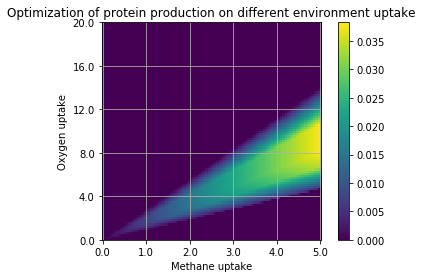

In [38]:
# plotting of the potential protein production as a function of methane and oxygen uptake

import numpy as np
import matplotlib.pyplot as plt

# we create a function to see how our protein production is optimize on different environments
def image_plot(model, precision, max_met, max_ox):
    plot = np.zeros([precision, precision])
    methane_vec = np.linspace(0,max_met,precision); oxygen_vec = np.linspace(0,max_ox,precision)
    for count_ox, oxygen in enumerate(oxygen_vec):
        for count_met, met in enumerate(methane_vec):
            #print(met, oxygen)
            model.reactions.r1160.bounds = oxygen, oxygen
            model.reactions.uptake_methane.bounds = met, met 
            result = model.optimize().objective_value
            if result < 0: 
                result = 0
            plot[(precision-1 - count_ox), count_met] = result
    label_met = np.round(np.linspace(0, max_met, 6),1)
    label_ox = np.round(np.linspace(max_ox, 0,6),1)
    ticks = np.linspace(0, precision - 1,6)
    imgplot = plt.imshow(plot)
    plt.colorbar()
    #plt.gca().invert_yaxis()
    plt.title("Optimization of protein production on different environment uptake")
    plt.xlabel("Methane uptake")
    plt.ylabel("Oxygen uptake")
    plt.xticks(ticks, label_met)
    plt.yticks(ticks, label_ox)
    plt.grid()
    return plot

max_met = 5; max_ox = 20; precision = 100
plot = image_plot(pheast_final, precision, max_met, max_ox)